# Example of generating a 1D2DRR model - an overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the delft3dfmpy python package.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook corresponds to a major update of delt3dfmpy and is, therefore, not compatible with older versions. The main differences are:
- input data should now be according the HyDAMO DAMO2.2 format instead of HyDAMO v12;
- input data is no longer in GML-format but is contained in a geopackage (GPKG);
- schematisation of paved nodes has changed. Within sewer areas, a paved node is created for every overflow location (which represents the corresponding fraction of the sewer area). Outside sewer areas, a paved node is created for the paved fraction of a catchment, which does NOT intersect with a sewage area;
- where the example catchment for older versions was the Moergestelsbroek, now the example model is based on a part of the Oostrumsche beek.


Jupyter-shortcuts:

    [H]: bekijken van alle shortcuts
    [SHIFT-Enter]: cel runnen en doorgaan
    [CNTRL-Enter]: runnen geselecteerde cellen
    [A]: nieuwe cel boven de huidge
    [B]: nieuwe cel onder de huidige
    [D-D]: cel verwijderen
    [SHIFT-TAB]: argumenten van functie weergeven (cel moet eerst gedraaid zijn)

## Initialize

Load Python libraries

In [65]:
# Basis
import os
import sys
import shutil
from platform import python_version
import numpy as np
sys.path.append('../')      
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString, Point

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

Change these paths to access the data and to use all functionalities. dflowfm_path is needed to refine the 2D-grid. It is not included in the D-Hydro installation. In the next major update, we will use meshkernel functionality and this executable will no longer be needed.

In [66]:
# path to the package containing the dummy-data
data_path = os.path.abspath('../data')

# path to dflowfm. Optional; needed for 2d-mesh refining
dflowfm_path = r'D:\3640.20\software\dflowfm-x64-1.2.104.66827M'

# path to write the models
output_path = os.path.abspath('demo_1DRR')

# path to DIMR for a correct run.bat file
dimr_path = r"C:\Program Files\Deltares\D-HYDRO Suite 2022.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dimr\scripts\run_dimr.bat"

In [67]:
# path to dll's that are needed to run gridgeom.dll, which is needed for 2D-mesh generation. Setting the path is only needed for Python >= version 3.8
if float('.'.join(python_version().split('.')[0:2])) >= 3.8: 
    dll_path = r'C:\Program Files\Deltares\D-HYDRO Suite 2022.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\share\bin'


## 1D-model

In [68]:
gpkg_file = os.path.join(data_path,'gpkg/Example_model.gpkg')
hydamo = HyDAMO(extent_file=os.path.join(data_path,'gis/OLO_subcatchment.shp'))
hydamo.branches.read_gpkg_layer(gpkg_file, layer_name='HydroObject', index_col='code')
# these branches are not connected to the main branch ('W_242466_0','W_242465_0','W_1386_0', 'W_2352_0') or have no profile (W_1698_0) - drop them.
branches_to_drop = ['W_242466_0','W_242465_0','W_1386_0', 'W_1698_0', 'W_2352_0']
hydamo.branches.drop(branches_to_drop, axis=0, inplace=True)
hydamo.profile.read_gpkg_layer(gpkg_file, layer_name='ProfielPunt', groupby_column = 'profiellijnid', order_column='codevolgnummer') 
hydamo.profile_roughness.read_gpkg_layer(gpkg_file, layer_name='RuwheidProfiel') 
hydamo.profile.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.profile.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.profile_line.read_gpkg_layer(gpkg_file, layer_name='profiellijn', id_col='globalid')
hydamo.profile_group.read_gpkg_layer(gpkg_file, layer_name='profielgroep')
hydamo.profile.drop('code', axis=1, inplace=True)
hydamo.profile['code'] = hydamo.profile['profiellijnid']
hydamo.param_profile.read_gpkg_layer(gpkg_file, layer_name='hydroobject_normgp')
hydamo.param_profile_values.read_gpkg_layer(gpkg_file, layer_name='normgeparamprofielwaarde')
hydamo.culverts.read_gpkg_layer(gpkg_file, layer_name='DuikerSifonHevel', index_col='code')
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.weirs.read_gpkg_layer(gpkg_file, layer_name='Stuw', index_col='code')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.opening.read_gpkg_layer(gpkg_file, layer_name='Kunstwerkopening')
hydamo.management_device.read_gpkg_layer(gpkg_file, layer_name='Regelmiddel')
hydamo.pumpstations.read_gpkg_layer(gpkg_file, layer_name='Gemaal',index_col='code')
hydamo.pumpstations.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.pumps.read_gpkg_layer(gpkg_file,layer_name='Pomp', index_col='code')
hydamo.management.read_gpkg_layer(gpkg_file, layer_name='Sturing', index_col='code')
hydamo.bridges.read_gpkg_layer(gpkg_file, layer_name='Brug', index_col='code')
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1100)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.boundary_conditions.read_gpkg_layer(gpkg_file, layer_name='hydrologischerandvoorwaarde', index_col='code')
hydamo.boundary_conditions.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)   
dfmmodel = DFlowFMModel()
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile, opening=hydamo.opening, management_device=hydamo.management_device, management=None)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, management_device=hydamo.management_device)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.management, gemalen=hydamo.pumpstations)
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=20.0, seperate_structures=True)
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    crosssections=hydamo.profile,
    crossection_roughness=hydamo.profile_roughness,
    param_profile=hydamo.param_profile,
    param_profile_values=hydamo.param_profile_values,   
    branches=hydamo.branches,
    roughness_variant = 'High'
)
j=0
missing = dfmmodel.crosssections.get_branches_without_crosssection()
hydamo.branches['order'] = np.nan
for i in hydamo.branches.naam.unique():
    if i != None:
        if all(x in missing for x in hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'code']) == False:
            hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'order'] = int(j)
            j=j+1
interpolation=[]
for i in hydamo.branches.itertuples():
    if i.order > 0:
        dfmmodel.network.set_branch_order(hydamo.branches.loc[i.Index,'code'], idx= int(hydamo.branches.at[i.Index,'order']))
        interpolation.append(hydamo.branches.loc[i.Index,'code'])
default = dfmmodel.crosssections.add_rectangle_definition(
        height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30, name='default')
missing_after_interpolation =np.setdiff1d(missing,interpolation)
dfmmodel.crosssections.set_default_definition(definition=default, shift=18.0)
default = dfmmodel.crosssections.add_rectangle_definition(
        height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30, name='default')
dfmmodel.crosssections.set_default_definition(definition=default, shift=18.0)
dfmmodel.crosssections.set_default_locations(missing_after_interpolation)
dfmmodel.external_forcings.io.from_hydamo(hydamo.boundary_conditions)
dfmmodel.external_forcings.add_boundary_condition('RVW_01', (197464.,392130.),  'discharge', 2.0)
# # Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

2022-06-30 15:24:16,256 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.


2022-06-30 15:24:16,262 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_1486_0 at: [0.0, 422.14700000000005, 593.3188859785391], due to the structures at [-0.001, 45.737, 64.128, 418.557, 425.737, 569.795, 593.3198859785391].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_1486_0 at: [0.0, 422.14700000000005, 593.3188859785391], due to the structures at [-0.001, 45.737, 64.128, 418.557, 425.737, 569.795, 593.3198859785391].


2022-06-30 15:24:16,268 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_153210_2 at: [0.0, 208.7465, 557.1781929021295], due to the structures at [-0.001, 203.426, 214.067, 255.862, 425.015, 557.1791929021294].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_153210_2 at: [0.0, 208.7465, 557.1781929021295], due to the structures at [-0.001, 203.426, 214.067, 255.862, 425.015, 557.1791929021294].


2022-06-30 15:24:16,276 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_2151_0 at: [0.0, 11.335, 39.908804212576065], due to the structures at [-0.001, 8.84, 13.83, 39.90980421257606].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_2151_0 at: [0.0, 11.335, 39.908804212576065], due to the structures at [-0.001, 8.84, 13.83, 39.90980421257606].


2022-06-30 15:24:16,279 - delft3dfmpy.core.dfm - dfm - WARNING - Structures D_24521, D_14808 have the same location.


2022-06-30 15:24:16,289 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_242202_0 at: [0.0, 664.1725, 1393.7647129348466], due to the structures at [-0.001, 445.275, 664.099, 664.246, 1044.64, 1219.205, 1393.7657129348465].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_242202_0 at: [0.0, 664.1725, 1393.7647129348466], due to the structures at [-0.001, 445.275, 664.099, 664.246, 1044.64, 1219.205, 1393.7657129348465].


2022-06-30 15:24:16,294 - delft3dfmpy.core.dfm - dfm - WARNING - Structures D_21450, D_19758 have the same location.


2022-06-30 15:24:16,297 - delft3dfmpy.core.dfm - dfm - WARNING - Structures D_19757, D_21451 have the same location.


2022-06-30 15:24:16,305 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_242219_0 at: [0.0, 22.600129343960525, 23.727258687921047], due to the structures at [-0.001, 21.573, 23.627258687921046, 23.72825868792105].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_242219_0 at: [0.0, 22.600129343960525, 23.727258687921047], due to the structures at [-0.001, 21.573, 23.627258687921046, 23.72825868792105].


2022-06-30 15:24:16,317 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_242226_0 at: [0.0, 0.172, 65.30601818575091], due to the structures at [-0.001, 0.1, 0.244, 65.30701818575092].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch W_242226_0 at: [0.0, 0.172, 65.30601818575091], due to the structures at [-0.001, 0.1, 0.244, 65.30701818575092].


2022-06-30 15:24:16,560 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of branches without cross section is: 56.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of branches without cross section is: 56.


2022-06-30 15:24:18,772 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 10.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 10.


2022-06-30 15:24:18,786 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of branches without cross section is: 9.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of branches without cross section is: 9.


## Read catchments and laterals

In [69]:
hydamo.catchments.read_gpkg_layer(gpkg_file, layer_name='afvoergebiedaanvoergebied', index_col='code')
hydamo.laterals.read_gpkg_layer(gpkg_file,layer_name='lateraleknoop')
for ind, cat in hydamo.catchments.iterrows():
    hydamo.catchments.loc[ind,'lateraleknoopcode'] = hydamo.laterals[hydamo.laterals.globalid==cat.lateraleknoopid].code.values[0]
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5000)

15.0 is MultiPolygon; split into single parts.
57.0 is MultiPolygon; split into single parts.
68.0 is MultiPolygon; split into single parts.
71.0 is MultiPolygon; split into single parts.
92.0 is MultiPolygon; split into single parts.
285.0 is MultiPolygon; split into single parts.
310.0 is MultiPolygon; split into single parts.
882.0 is MultiPolygon; split into single parts.


## Generate the RR schematization

Catchments are provided in the HyDAMO DAMO2.2 format and included in the GPKG. They can also be read from other formats using 'read_gml', or 'read_shp'. Note that in case of shapefiles column mapping is necessary because the column names are truncated. 

Note that when catchments have a "MultiPolygon' geometry, the multipolygons are 'exploded' into single polygon geometries. A warning of this is isued, and a suffix is added to every polygons ID to prevent duplicates. 

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.
 
At the moment, two options exist for the schematisation of the paved area:
 1) simple: the paved fraction of each catchment is modelled with a paved node, directly connected to catchments' boundary node
 <br>
 2) more complex: sewer area polygons and overflow points are used a input as well. For each sewer area, the overlapping paved area is the distributed over the overflows that are associated with the sewerarea (the column 'lateraleknoopcode') using the area fraction (column 'fractie') for each overflow. In each catchment, paved area that does not intersect with a sewer area gets an unpaved node as in option (1).

First read sewer areas and overflow locations.

In [70]:
hydamo.sewer_areas.read_shp(os.path.join(data_path , 'gpkg',  'rioleringsgebieden.shp'),clip=None, check_geotype=False, column_mapping={'Code':'code'})
hydamo.overflows.read_shp(os.path.join(data_path,  'gpkg' , 'overstorten.shp') ,clip=None, column_mapping={'codegerela':'codegerelateerdobject', 'naam_riole':'name' })
hydamo.overflows.snap_to_branch(hydamo.branches, snap_method='overal', maxdist= 5000)

Create in instance of a DFlowRRModel and set the parameters.

Other input data for RR can be fed by rasters (from which zonal statistics will be extracted) or spatially uniform default values. Three rasters are required: land use, soil type and surface elevation. For each land use type, the area within each catchment is calculated. Surface level is calculated as the median within the catchment, and the most-occurring soil type is used. In all rasters, a NODATA-value of -999 should be used.

In [71]:
drrmodel = DFlowRRModel()

For land use and soil type a coding is prescribed. For landuse, the legend of the map is expected to be as follows: <br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in m+NAP.

### Unpaved areas

Fill the unpaved node with the corresponding ernst definition as follows. 

The argument 'meteo_areas' to 'unpaved_from_input' contains the polygons that correspond to a meteo-station: here these are identical to each catchment so each catchment gets its own station.  If there are many, small, catchments, it might be more appropriate to use, for instance, Thiessen polygons around gauges. For each catchment, the meteo-station is based on the 'meteo-area;-feature in which the centroid of the catchment falls.

The argument 'zonalstats_alltouched' is rather important. It defines the number of cells in the input rasters that are taken into account for each catchment. If the raster resolution is sufficiently high, its setting does not matter. In the case of coarse rasters, small catchments might end up with no nodes at all if the 'zonalstats_alltouched' is FALSE - it says that only cells of which the centroids are inside the polygon are taken into account. If it is TRUE, all cells that are touched by the catchment geometry are taken into account - i.e. some pixels might be counted multiple times. Note that to define average fluxes (meteo, seepage, storages) zonalstats_alltouched is TRUE by default. For elevation, land use and soil types it is FALSE by default, if the argument is omitted.

In [72]:
# # all data and settings to create the RR-model
# all data and settings to create the RR-model
lu_file = os.path.join(data_path , 'rasters' ,'sobek_landuse.tif')
ahn_file = os.path.join(data_path ,'rasters' , 'AHN_2m_clipped_filled.tif')
soil_file = os.path.join(data_path , 'rasters' , 'sobek_soil.tif')
surface_storage = 10.0
infiltration_capacity = 100.0
initial_gwd = 1.2 # water level depth below surface

runoff_resistance = 1.
infil_resistance = 300.
layer_depths = [0.0, 1.0, 2.0]
layer_resistances = [30,200,10000]

meteo_areas = hydamo.catchments

drrmodel.unpaved.io.unpaved_from_input(hydamo.catchments, lu_file, ahn_file, soil_file, surface_storage, infiltration_capacity, initial_gwd, meteo_areas, zonalstats_alltouched=True)
drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances,infiltration_resistance=infil_resistance, runoff_resistance=runoff_resistance)

### Paved areas

Input for the paved nodes are land use -the area of the paved node is the area of class '14' in the provided land use map- and surface elevation. In addition, the following parameters can all be numbers (spatially uniform) or raster filenames:
- storage on the street (in mm)<br>
- storage in the sewer system (in mm)<br>
- capacity of the sewerpumps (in m3/s)<br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [86]:
street_storage = 10.0
sewer_storage =  10.0 #s.path.join(data_path,'rasters/sewstor.tif')
pumpcapacity =  10.0 #os.path.join(data_path,'rasters/pumpcap.tif')

# version with sewer areas and overflows
drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
                                    landuse=lu_file, 
                                    surface_level=ahn_file,  
                                    sewer_areas=hydamo.sewer_areas,
                                   overflows=hydamo.overflows,
                                    street_storage=street_storage,
                                    sewer_storage=sewer_storage,
                                    pump_capacity=pumpcapacity, 
                                    meteo_areas=meteo_areas,
                                    zonalstats_alltouched=True)

2022-06-30 15:47:54,878 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 71.0_0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 71.0_0


2022-06-30 15:47:54,894 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 71.0_1


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 71.0_1


2022-06-30 15:47:55,499 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 298.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 298.0


2022-06-30 15:47:55,624 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 307.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 307.0


2022-06-30 15:47:55,854 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 432.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 432.0


2022-06-30 15:47:56,232 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 882.0_1


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 882.0_1


### Greenhouse areas

Input for the greenhouse nodes are (again) land use -the area of the paved node is the area of class '15' in the provided land use map- and surface elevation. In addition, the following parameter can be a number (spatially uniform) or a raster filename:
- storage on the roof <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [74]:
roof_storage = 10.0 #os.path.join(data_path,'rasters/roofstor.tif')
drrmodel.greenhouse.io.greenhouse_from_input(hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas, zonalstats_alltouched=True)

### Open water areas

Input for the open water nodes are only land use -the area of the paved node is the area of class '13' in the provided land use map. 

The meteo-station is assigned in the same way as for unpaved nodes.

In [75]:
drrmodel.openwater.io.openwater_from_input(hydamo.catchments, lu_file, meteo_areas, zonalstats_alltouched=True)

### Boundary nodes

Boundary nodes are assumed to be also included in the FM-model. For every catchment, the boundary identified by 'lateraleknoopocode' in the catchment definitition, is assumed to exist in the laterals. 

These nodes are created in the RR model with the same ID. 'drrmodel' is an argument because the function checks whether boundary nodes have a valid connection to anyo other node; other boundaries are removed. Overflows are optional and can be left out. If they are included, additional boundaries are created.

In [76]:
drrmodel.external_forcings.io.boundary_from_input(hydamo.laterals, hydamo.catchments, drrmodel, overflows=hydamo.overflows)

2022-06-30 15:24:35,837 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - Adding overflows to the boundary nodes.


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:Adding overflows to the boundary nodes.


Coupling between RR and FM must be online (parallel), not sequential. RR reads waterlevels from FM laterals and FM gets discharges from lateral nodes of discharge type 'realtime'. In the call to the function, the overflow locations are appended to the regular lateral locations. For lateral nodes for which no rr_boundary (catchment or overflow) exists, a time series from lateral_discharge is used. Lateral discharges can be of two types:
- a Pandas series, that contains one number (in m3/s) for every lateral. The 'code' of the lateral should be the index of the series. See example below.
- a Pandas dataframe containing time series, with a column for every lateral node. The 'code' of the lateral should be equal to the column names, and the index should contain the timestamps.

In [77]:
dfmmodel.external_forcings.io.read_laterals(locations=hydamo.laterals.append(hydamo.overflows), lateral_discharges=None, rr_boundaries=drrmodel.external_forcings.boundary_nodes)

### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

Precipitation and evaporation are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved. For seepage, as the use of Metaswap-rasters is allowed, the unit is assumed to m3/grid cell/timestep.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.

IMPORTANT: time steps are extracted from the file names. Therefore, the names should cohere to some conditions:
The filename should consist of at least two parts, separated by underscores. The second part needs to contain time information, which should be formatted as YYYYMMDDHHMMSS (SS may be omitted). Or, for daily data YYYYMMDD.

For example: 'precip_20200605151500.tif'

In [78]:
seepage_folder = os.path.join( data_path, 'rasters', 'seepage')
precip_folder =  os.path.join(data_path, 'rasters',  'precipitation')
evap_folder = os.path.join( data_path, 'rasters',  'evaporation')

drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder)
drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder)

Reading seepage files:   0%|          | 0/3 [00:00<?, ?it/s]

Reading precipitation files:   0%|          | 0/72 [00:00<?, ?it/s]

Reading evaporation files:   0%|          | 0/3 [00:00<?, ?it/s]

## Plotting and writing

We need a function to plot the RR-nodes

In [79]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point
    geoms = []  
    links = []
    for i in dict.items():
        if 'ar' in i[1]:
            if np.sum([float(s) for s in i[1]['ar'].split(' ')])>0:
                geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
                links.append(LineString((Point(float(i[1]['px']),float(i[1]['py'])),
                                        Point(float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['px']),
                                              float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['py'])))))
        else: 
            geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
    return((gpd.GeoDataFrame(geoms,columns=['geometry'])),gpd.GeoDataFrame(links,columns=['geometry']))

Now all the nodes are filled. The topology is defined as follows: every catchment gets a maximum of four nodes (unpaved, paved, open water and greenhouse). If in the land use map, the appropriate land use does not occur in the catchment, no node is defined. The four nodes are plotted on a horizontal (west-east) line around the catchment centroid in the order of: openwater, unpaved, paved, greenhouse. Every node is connected with the lateral node of the catchnment using a RR-link. The files 3B_NOD.TP and 3B_LINK.TP are created describing this.

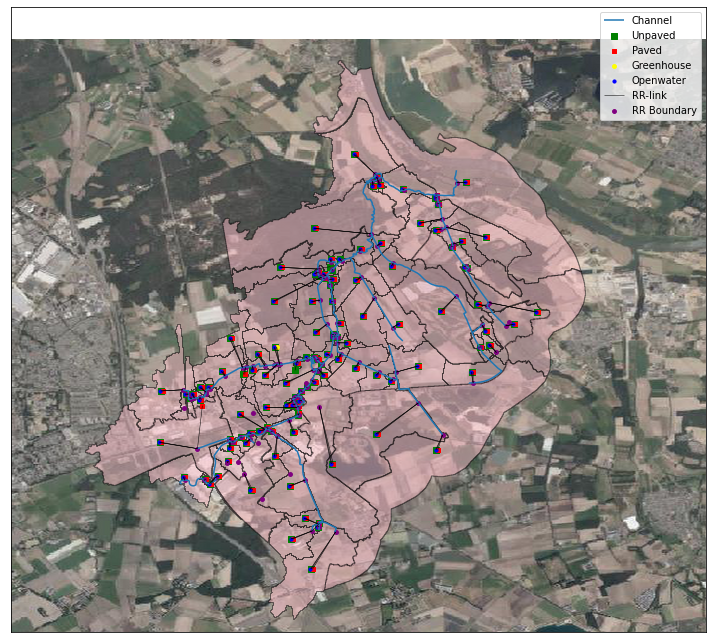

In [80]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(195000, 205000)
ax.set_ylim(390000, 399000)

achtergrond = plt.imread( os.path.join(data_path,'gis/achtergrond_oostrum.png'))
ax.imshow(achtergrond, extent=(189287, 210845, 389693, 398529), interpolation='lanczos')

hydamo.catchments.plot(ax=ax,label='Catchments', edgecolor='black', facecolor="pink", alpha=0.5)
hydamo.branches.plot(ax=ax, label='Channel')
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(ax=ax,markersize=30,marker='s',color='green',label='Unpaved')
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax,markersize=20,marker='s',color='red',label='Paved')
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax,markersize=15,color='yellow',label='Greenhouse')
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax,markersize=10,color='blue',label='Openwater')
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color='black',linewidth=0.5,label='RR-link')
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(ax=ax, markersize=15, color='purple',label='RR Boundary')

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor='pink', edgecolor='black',alpha=0.5)
ax.legend(handles=handles.append(poly),labels=labels.append('Catchments'))
fig.tight_layout()

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. 

For every paved node, a sewage link to a WWTP is created. This is not included in the data, and will be created (including a boundary outside the model) at the coordinates specified by the 'wwtp' argument in the rr_writer below.

In [81]:
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20160601
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] =  24.0 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7
dfmmodel.mdu_parameters['OutputDir'] = 'output'
dfmmodel.mdu_parameters['useVolumeTables'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['increment'] = 0.2 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoForcedFlush'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['MapFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoUnlimited'] = 1 # oparameter setting advised by Deltares for better performance

# # for RR model
drrmodel.d3b_parameters['Timestepsize'] = 300
drrmodel.d3b_parameters['StartTime'] = "'2016/06/01;00:00:00'" # should be equal to refdate for D-HYDRO
drrmodel.d3b_parameters['EndTime'] = "'2016/06/03;00:00:00'"
drrmodel.d3b_parameters['RestartIn'] = 0
drrmodel.d3b_parameters['RestartOut'] = 0
drrmodel.d3b_parameters['RestartFileNamePrefix'] ='Test'
drrmodel.d3b_parameters['UnsaturatedZone'] = 1
drrmodel.d3b_parameters['UnpavedPercolationLikeSobek213']=-1
drrmodel.d3b_parameters['VolumeCheckFactorToCF']=100000
drrmodel.dimr_path = dimr_path
print('Writing model')

# # Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir= output_path, name='demo_simple')
rr_writer = DFlowRRWriter(drrmodel, output_dir= output_path, name='demo_simple',wwtp=(199000.,396000.))

# # Write as model
# # The ldb is just for visualising in the interaktor - there is no RR component there.
fm_writer.objects_to_ldb()
fm_writer.write_all()
rr_writer.write_all()

Writing model


Zip the model output for download.

In [82]:
shutil.make_archive('demo_model_1DRR', 'zip', output_path)

'D:\\3640.20\\delft3dfmpy_training\\notebooks\\demo_model_1DRR.zip'

Finished! Start the coupled model by clicking run.bat in the output model, or import the dimr_config.xml in the GUI.